In [1]:
import li.analysis as la
import li.EvaluationHelpers as eh

import os
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt

# from lithium.Lithium_Properties_2D_750G import m_Li6

# Data Loading and Definition of Variables

In [2]:
# path to images
images_set = "E-Temperature_vs_B"

path_dir = "Z:/Archiv/2D/Experiment/2025/20250203/Images20250203/" + images_set + "/"
path_file = os.listdir(path_dir)

In [3]:
# grab loop variable names
variables = la.loop_variables(path_dir + path_file[0])[1]
var_vals = la.loop_variables(path_dir + path_file[0])[0]

In [4]:
variables

['i', 'FB_Img']

In [5]:
# experiment variables loaded from experiment control
info = la.GetImageMetadata(path_dir + path_file[-1])
info_sorted = dict(sorted(info[0].items(), key=lambda x: x[0].lower()))
# info_sorted

# Image Processing

In [6]:
%%time
# create initial dictionary with all raw images
images_raw = eh.createImageInfoList([path_dir], variables)

CPU times: total: 15.6 ms
Wall time: 194 ms


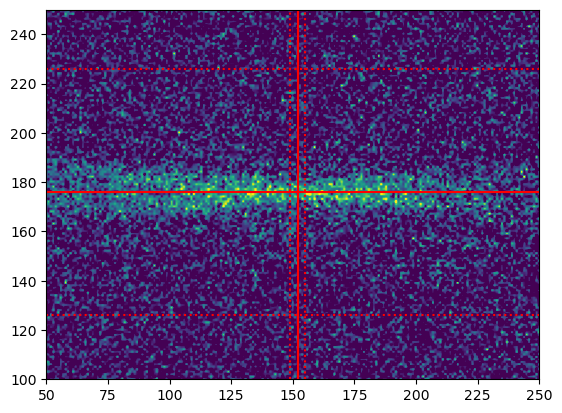

In [7]:
# determine optimal ROI
center = (176, 152)
h = 50
w = 3

single_prc = la.density_builder([images_raw[3]], variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = True)

plt.imshow(single_prc.iloc[0]["density"].data, vmin = 0, vmax = 3, cmap = "viridis")

plt.xlim(50, 250)
plt.ylim(100, 250)


plt.axhline(center[0], c = "red")
plt.axhline(center[0] - h, c = "red", ls = ":")
plt.axhline(center[0] + h, c = "red", ls = ":")

plt.axvline(center[1], c = "red")
plt.axvline(center[1] - w, c = "red", ls = ":")
plt.axvline(center[1] + w, c = "red", ls = ":")


plt.show()

In [8]:
%%time
# calculate all density images and apply mask
images_prc = la.density_builder(images_raw, variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = False)

|████████████████████████████████████████| 400/400 [100%] in 38.4s (10.40/s)    
CPU times: total: 18.2 s
Wall time: 38.5 s


In [9]:
var_vals[1]

array([750., 760., 770., 780., 790., 800., 810., 820.])

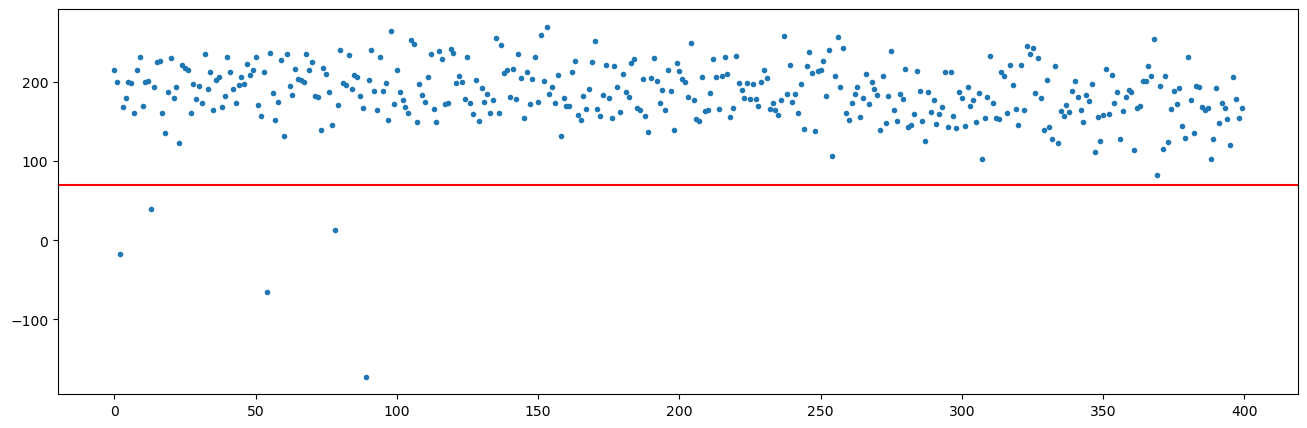

In [10]:
# filter out missed shots
bol = []

for rate in var_vals[1]:

    for i, im in images_prc[images_prc["FB_Img"] == rate].iterrows():
        bol.append(np.sum(im["density"].compressed()))

plt.figure(figsize = (16, 5))

plt.plot(bol, ".")
plt.axhline(70, c = "r")

plt.ylim(None, None)

plt.show()

In [11]:
%%time
# filter missed shots
images_fil = la.filter(images_prc, 70)

CPU times: total: 62.5 ms
Wall time: 46 ms


In [12]:
%%time
# group by loop variables and average over iterations
images_grp = la.group(images_fil, variables, "i")

CPU times: total: 516 ms
Wall time: 527 ms


In [13]:
%%time
# make T4 fits 
images_fit = la.T4_fit(images_grp)

CPU times: total: 62.5 ms
Wall time: 57 ms


In [14]:
%%time
# calculate response
# images_res = la.response(images_fit)

CPU times: total: 0 ns
Wall time: 0 ns


# Visualization

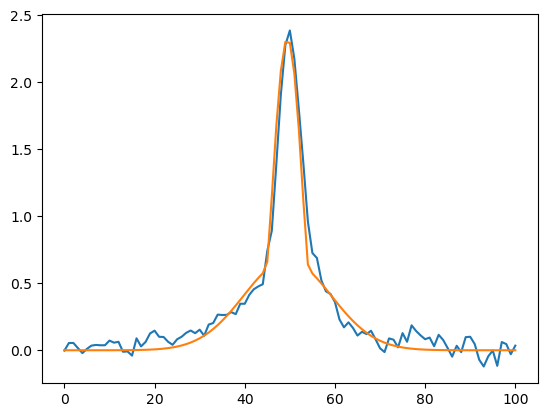

[4.899224884107335, 0.43961541541774374]


In [15]:
field = 0

T4 = np.mean(images_fit["density"].iloc[field], axis = 1).compressed()
pos = np.arange(0, len(T4))

plt.plot(pos, T4)

plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), images_fit["T4_params"].iloc[field][0],
                                                          images_fit["T4_params"].iloc[field][1],
                                                          images_fit["T4_params"].iloc[field][2],
                                                          images_fit["T4_params"].iloc[field][3],
                                                          images_fit["T4_params"].iloc[field][4],))

# plt.plot(pos, parab(pos, 2.3, 50, 5))

plt.show()

print(images_fit["temperature"].iloc[field])

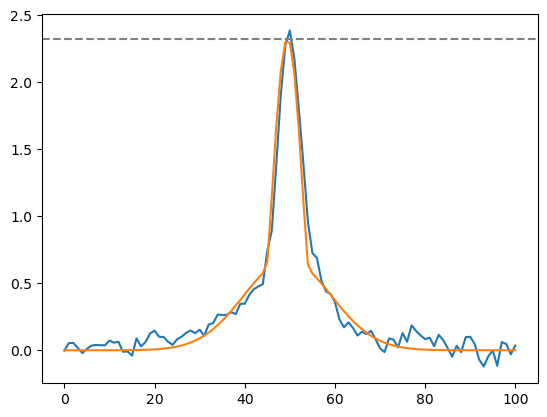

Temperature 4.90 +- 0.44 nK @ 750 G



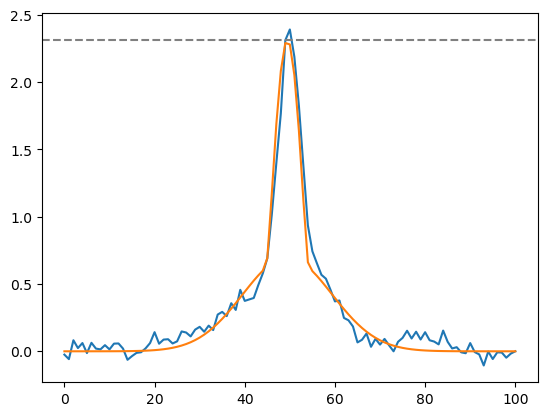

Temperature 5.15 +- 0.42 nK @ 760 G



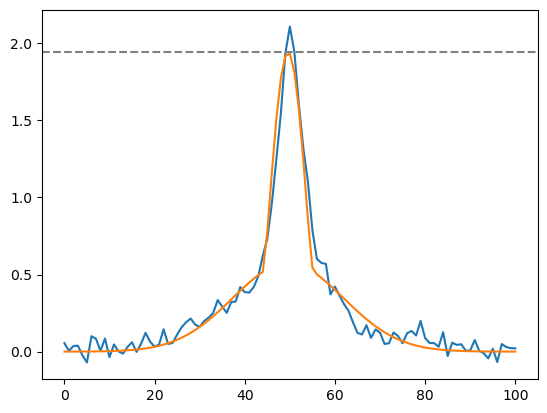

Temperature 7.88 +- 0.69 nK @ 770 G



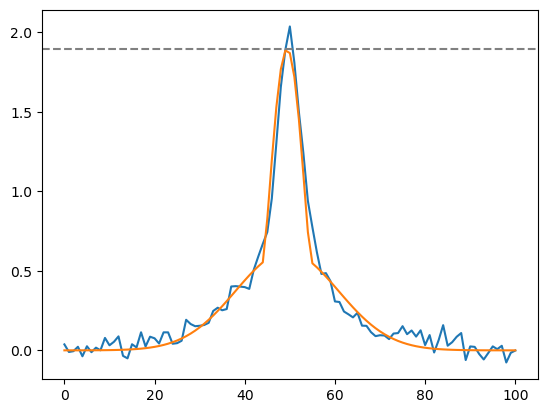

Temperature 6.76 +- 0.54 nK @ 780 G



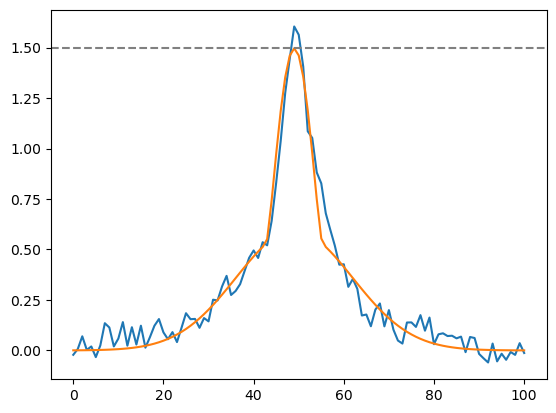

Temperature 8.77 +- 0.73 nK @ 790 G



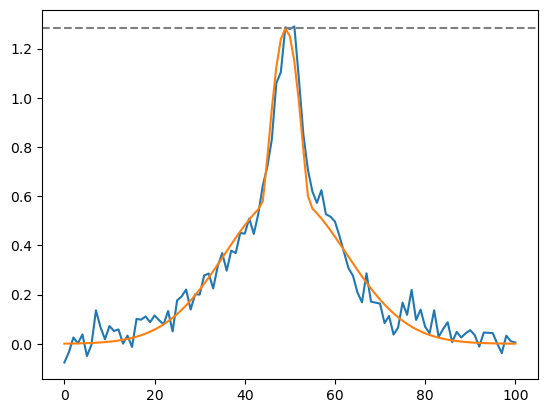

Temperature 9.42 +- 0.57 nK @ 800 G



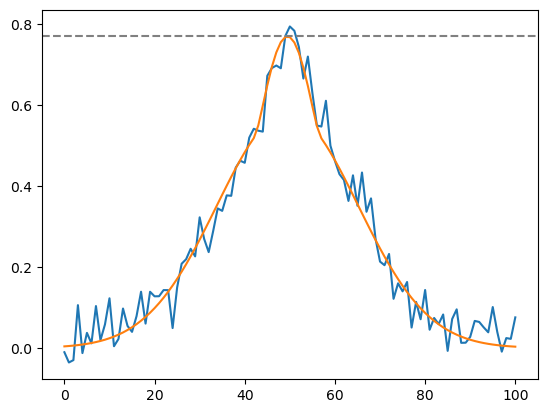

Temperature 12.80 +- 0.62 nK @ 810 G



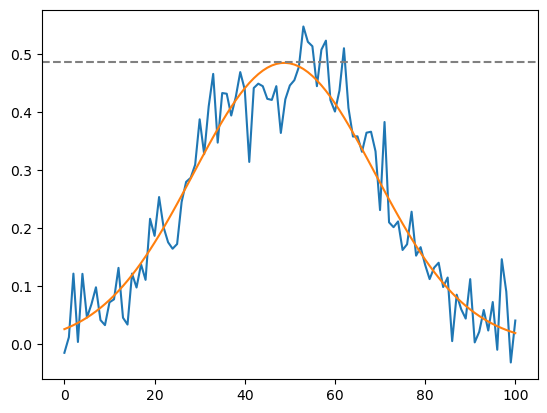

Temperature 21.25 +- 1.04 nK @ 820 G



In [18]:
for i, im in images_fit.iterrows():

    T4 = np.mean(im["density"], axis = 1).compressed()
    pos = np.arange(0, len(T4))

    plt.plot(pos, T4)

    plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), im["T4_params"][0],
                                                              im["T4_params"][1],
                                                              im["T4_params"][2],
                                                              im["T4_params"][3],
                                                              im["T4_params"][4],))

    # plt.axhline(im["T4_params"][0] + im["T4_params"][3], color = "grey", ls = "--")
    plt.axhline(im["T4_peak"], color = "grey", ls = "--")

    plt.show()

    print(f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK @ {im["FB_Img"]:.0f} G")
    # print(im["T4_params"])
    print("")

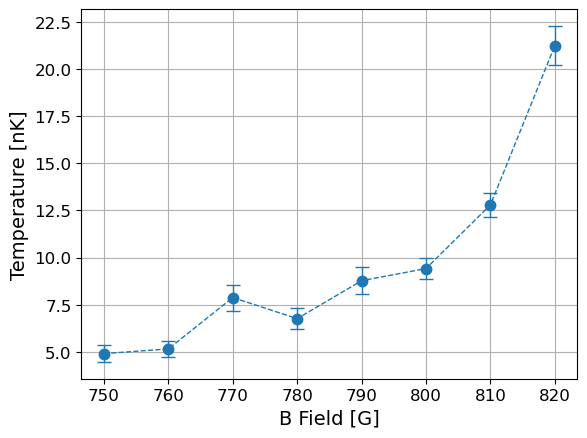

In [17]:
B = np.array(images_fit["FB_Img"].tolist())
T = np.array(images_fit["temperature"].tolist())

plt.errorbar(B, T[:, 0], T[:, 1], marker = ".", ms = 15, lw = 1, ls = "--", elinewidth = 1, capsize = 5)

plt.xlabel("B Field [G]", fontsize = 14)
plt.ylabel("Temperature [nK]", fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid(visible = True, which = "both")

plt.show()